#** [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)**
* 개와 고양이 이미지에 대해 학습한 뒤, 입력 이미지가 개일 확률을 구하는 문제
* Data 설명
  - Color depth: RGB color image (jpg)
  - image size: 다양
  - 이미지 유형
    + 얼굴만 존재 / 몸통 일부도 포함 / 몸통 전체 포함
    + 정면뿐만이 아니라, 다양한 방향과 각도에서 촬영된 이미지 존재
    + 이미지에 꽉차게 존재 vs. 일부 영역에 존재
    + occlusion 존재하는 경우도 있음
    + focus out 이미지 존재
    + 그래픽이 가미된 편집 이미지 존재
  - 개수
    + train: 25,000 장
    + test: 12,500 장
    
* Reference
  - Kaggle kernel
    + [CatdogNet - Keras Convnet Starter](https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter)
    + [Full Classification Example with ConvNet](https://www.kaggle.com/sentdex/full-classification-example-with-convnet/code)

##**Colab: Google Drive File Access**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
import zipfile
import os, os.path

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1dleRLnwKzvPmyGF4Dq2P05qT2cZY9Xw2'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.zip')
downloaded = drive.CreateFile({'id':'1rWdtrmlANzYnGTaWSP_fAmOXDg0BEmFx'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test.zip')

In [4]:
!ls -l

total 834388
drwxr-xr-x 4 root root      4096 May 17 02:54 data
drwxr-xr-x 1 root root      4096 May 17 02:53 datalab
-rw-r--r-- 1 root root 284478493 May 17 05:59 test.zip
-rw-r--r-- 1 root root 569918665 May 17 05:59 train.zip


In [0]:
def ExtractZip(zipPath, dataPath, dataType, dataNum):
  
    # 해당 폴더가 존재하는지 확인
    doExtract = True
    targetPath = dataPath + "/" + dataType
    if os.path.isdir(targetPath):
        numFile = len(os.listdir(targetPath))
        if numFile == dataNum:
            doExtract = False
    
    if doExtract == True:
        objZip = zipfile.ZipFile(zipPath)
        objZip.extractall(dataPath)
        print("[%s] is extracted to [%s](%d)." %(zipPath, targetPath, len(os.listdir(targetPath))))
    else:
        print("[%s] is already extracted to [%s](%d)." %(zipPath, targetPath, len(os.listdir(targetPath))))

In [0]:
DataPath = './data'

In [7]:
ExtractZip('./train.zip', DataPath, "train", 25000)

[./train.zip] is already extracted to [./data/train](25000).


In [8]:
ExtractZip('./test.zip', DataPath, "test", 12500)

[./test.zip] is already extracted to [./data/test](12500).


In [0]:
from IPython.display import Image

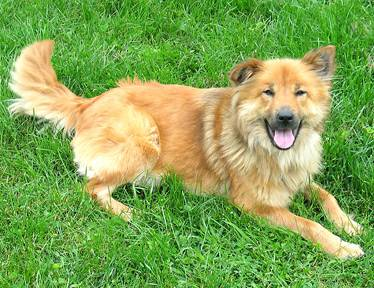

In [10]:
Image('/content/data/test/4.jpg')

##**Train/Test data preparation**

In [11]:
!pip install -U tqdm
!pip install -U ipywidgets

import os, cv2, random
import numpy as np
from tqdm import tqdm
from tqdm import trange, tnrange, tqdm_notebook
from ipywidgets import IntProgress
from time import sleep
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.23.3)
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.6/dist-packages (7.2.1)
Requirement not upgraded as not directly required: ipykernel>=4.5.1 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.6.1)
Requirement not upgraded as not directly required: ipython>=4.0.0; python_version >= "3.3" in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (5.5.0)
Requirement not upgraded as not directly required: widgetsnbextension~=3.2.0 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (3.2.1)
Requirement not upgraded as not directly required: traitlets>=4.3.1 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.3.2)
Requirement not upgraded as not directly required: nbformat>=4.2.0 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.4.0)
Requirement not upgraded as not directly required: tornado>=4.0 in /usr/local/lib/python3.6/dist-packages (f

In [0]:
TRAIN_DIR = '/content/data/train/'
TEST_DIR = '/content/data/test/'

ROWS = 64
COLS = 64
CHANNELS = 3


def read_image(file_path):
  
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
  
    count = len(images)
    #data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(tqdm(images)):
        image = read_image(image_file)
        # data[i] = image.T
        data[i] = image
    
    return data

  
def labeling(images):
  
  labels = np.ndarray((len(images), 1), dtype=np.uint8)

  for i, image_file in enumerate(images):
      if 'dog' in image_file:
          labels[i] = 1
      else:
          labels[i] = 0
  return labels

In [13]:
print("[Load image filename list]")
sleep(0.5)

train_images = [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR))] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR)) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR)) if 'cat' in i]
test_images =  [TEST_DIR+i for i in tqdm(os.listdir(TEST_DIR))]

random.shuffle(train_dogs)
random.shuffle(train_cats)


# data reduction for model build-up efficiency
DataCoverage = 0.1

noTrainDogs = int(len(train_dogs) * DataCoverage)
noTrainCats = int(len(train_cats) * DataCoverage)

train_dogs =  train_dogs[:noTrainDogs]
train_cats =  train_cats[:noTrainCats]

test_images =  test_images[:25]


# split train data into real train data and validation data
TrainDataRatio = 0.7

noTrainDogs = int(len(train_dogs) * TrainDataRatio)
noTrainCats = int(len(train_cats) * TrainDataRatio)

train_images = train_dogs[:noTrainDogs] + train_cats[:noTrainCats]
random.shuffle(train_images)

valid_images = train_dogs[noTrainDogs:] + train_cats[noTrainCats:]
random.shuffle(valid_images)

print("")
print("- Train image count: ", len(train_images))
print("- Validation image count: ", len(valid_images))


print("")
print("[Image loading..]")
train = prep_data(train_images)
valid = prep_data(valid_images)
test = prep_data(test_images)

print("")
print("Train shape: {}".format(train.shape))
print("Vadli shape: {}".format(valid.shape))
print("Test shape: {}".format(test.shape))

print("")
print("[Label loading..]")
train_labels = labeling(train_images)
valid_labels = labeling(valid_images)

print("Train image label shape: {}".format(train_labels.shape))
print("Validation image label shape: {}".format(valid_labels.shape))

[Load image filename list]


  3%|▎         | 50/1750 [00:00<00:03, 498.62it/s]


- Train image count:  1750
- Validation image count:  750

[Image loading..]


100%|██████████| 25/25 [00:00<00:00, 477.71it/s]


Train shape: (1750, 64, 64, 3)
Vadli shape: (750, 64, 64, 3)
Test shape: (25, 64, 64, 3)

[Label loading..]
Train image label shape: (1750, 1)
Validation image label shape: (750, 1)


##**Build Model: CNN**
* Reference
  - [hunkim: DeepLearningZeroToAll] [lab-11-4-mnist_cnn_layers.py](https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-11-4-mnist_cnn_layers.py)

In [0]:
import tensorflow as tf
# import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility

class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
      
        with tf.variable_scope(self.name):
        
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, ROWS, COLS, CHANNELS])

            # img 28x28x1 (black/white), Input Layer
            # X_img = tf.reshape(self.X, [-1, ROWS, COLS, CHANNELS])
            self.Y = tf.placeholder(tf.int32, [None, 1])
            
            Y_one_hot = tf.one_hot(self.Y, 2)
            Y_one_hot = tf.reshape(Y_one_hot, [-1, 2])

            # Convolutional and Polling Layer #1
            conv1 = tf.layers.conv2d(inputs=self.X, filters=32, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=self.training)
            
            # Convolutional and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=self.training)

            # Convolutional and Pooling Layer #3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3, rate=0.3, training=self.training)

            # Convolutional and Pooling Layer #4
            conv4 = tf.layers.conv2d(inputs=dropout3, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
            pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], padding="same", strides=2)
            dropout4 = tf.layers.dropout(inputs=pool4, rate=0.3, training=self.training)
            
            # Dense Layer with Relu
            flat = tf.reshape(dropout4, [-1, 256 * 4 * 4])
            dense5 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
            dropout5 = tf.layers.dropout(inputs=dense5, rate=0.5, training=self.training)
            
            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout5, units=2)
            
            
        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=Y_one_hot))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
      return self.sess.run(self.logits, feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
      return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
      return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})


##**Train**

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Batch loop:   0%|          | 0/17 [00:00<?, ?it/s]

Train data count:  1750 1750
Validation data count:  750 750
Learning Started!


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.30it/s]


Epoch: 0001 cost = 74.032445739 accuracy= 0.035999998


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.20it/s]


Epoch: 0002 cost = 0.768649859 accuracy= 0.001333333


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.01it/s]


Epoch: 0003 cost = 0.710694562 accuracy= 0.071999997


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.32it/s]


Epoch: 0004 cost = 0.701114416 accuracy= 0.002666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.19it/s]


Epoch: 0005 cost = 0.703133075 accuracy= 0.013333334


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.47it/s]


Epoch: 0006 cost = 0.698816257 accuracy= 0.008000000


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.37it/s]


Epoch: 0007 cost = 0.691943011 accuracy= 0.010666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.81it/s]


Epoch: 0008 cost = 0.698410711 accuracy= 0.004000000


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.85it/s]


Epoch: 0009 cost = 0.697798904 accuracy= 0.345333338


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.32it/s]


Epoch: 0010 cost = 0.695540397 accuracy= 0.000000000


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.98it/s]


Epoch: 0011 cost = 0.692920296 accuracy= 0.494666666


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.86it/s]


Epoch: 0012 cost = 0.691246145 accuracy= 0.282666653


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 20.94it/s]


Epoch: 0013 cost = 0.688108570 accuracy= 0.001333333


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.70it/s]


Epoch: 0014 cost = 0.686248846 accuracy= 0.151999995


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.34it/s]


Epoch: 0015 cost = 0.686542111 accuracy= 0.000000000


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.01it/s]


Epoch: 0016 cost = 0.695587663 accuracy= 0.033333335


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.17it/s]


Epoch: 0017 cost = 0.675265540 accuracy= 0.002666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.13it/s]


Epoch: 0018 cost = 0.686485634 accuracy= 0.182666659


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.55it/s]


Epoch: 0019 cost = 0.677627581 accuracy= 0.094666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.56it/s]


Epoch: 0020 cost = 0.672792070 accuracy= 0.057333332


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.89it/s]


Epoch: 0021 cost = 0.669787147 accuracy= 0.159999996


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.62it/s]


Epoch: 0022 cost = 0.671310232 accuracy= 0.112000003


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.26it/s]


Epoch: 0023 cost = 0.661442564 accuracy= 0.104000002


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.88it/s]


Epoch: 0024 cost = 0.663897791 accuracy= 0.125333339


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.22it/s]


Epoch: 0025 cost = 0.665791000 accuracy= 0.129333332


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.88it/s]


Epoch: 0026 cost = 0.652827098 accuracy= 0.256000012


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.34it/s]


Epoch: 0027 cost = 0.657635980 accuracy= 0.085333332


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.70it/s]


Epoch: 0028 cost = 0.644346581 accuracy= 0.075999998


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.01it/s]


Epoch: 0029 cost = 0.645222762 accuracy= 0.113333337


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.61it/s]


Epoch: 0030 cost = 0.647489499 accuracy= 0.101333335


Batch loop:  12%|█▏        | 2/17 [00:00<00:00, 19.89it/s]


Epoch: 0031 cost = 0.644493878 accuracy= 0.166666672


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.56it/s]


Epoch: 0032 cost = 0.656165105 accuracy= 0.148000002


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.51it/s]


Epoch: 0033 cost = 0.640418961 accuracy= 0.244000003


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.51it/s]


Epoch: 0034 cost = 0.637674809 accuracy= 0.145333335


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.92it/s]


Epoch: 0035 cost = 0.634265262 accuracy= 0.193333328


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.57it/s]


Epoch: 0036 cost = 0.638047345 accuracy= 0.078666665


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.32it/s]


Epoch: 0037 cost = 0.636540374 accuracy= 0.090666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.50it/s]


Epoch: 0038 cost = 0.635047317 accuracy= 0.314666659


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.67it/s]


Epoch: 0039 cost = 0.627687465 accuracy= 0.344000012


Batch loop:  12%|█▏        | 2/17 [00:00<00:00, 19.75it/s]


Epoch: 0040 cost = 0.626860699 accuracy= 0.441333324


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.05it/s]


Epoch: 0041 cost = 0.629683859 accuracy= 0.268000007


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.51it/s]


Epoch: 0042 cost = 0.626079994 accuracy= 0.391999990


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.62it/s]


Epoch: 0043 cost = 0.614256929 accuracy= 0.441333324


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.96it/s]


Epoch: 0044 cost = 0.633411975 accuracy= 0.151999995


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.34it/s]


Epoch: 0045 cost = 0.625785470 accuracy= 0.280000001


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.61it/s]


Epoch: 0046 cost = 0.631847757 accuracy= 0.274666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.86it/s]


Epoch: 0047 cost = 0.661650738 accuracy= 0.206666663


Batch loop:  12%|█▏        | 2/17 [00:00<00:00, 19.75it/s]


Epoch: 0048 cost = 0.635930345 accuracy= 0.358666658


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.21it/s]


Epoch: 0049 cost = 0.624255061 accuracy= 0.401333332


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.22it/s]


Epoch: 0050 cost = 0.612069270 accuracy= 0.234666660


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 20.88it/s]


Epoch: 0051 cost = 0.584146624 accuracy= 0.266666681


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.24it/s]


Epoch: 0052 cost = 0.620622439 accuracy= 0.553333342


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.67it/s]


Epoch: 0053 cost = 0.632749252 accuracy= 0.430666655


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.01it/s]


Epoch: 0054 cost = 0.632318514 accuracy= 0.439999998


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.14it/s]


Epoch: 0055 cost = 0.591594927 accuracy= 0.422666669


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.90it/s]


Epoch: 0056 cost = 0.607228879 accuracy= 0.530666649


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.11it/s]


Epoch: 0057 cost = 0.604781540 accuracy= 0.469333321


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 20.84it/s]


Epoch: 0058 cost = 0.600507621 accuracy= 0.398666680


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.93it/s]


Epoch: 0059 cost = 0.598195560 accuracy= 0.478666663


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.09it/s]


Epoch: 0060 cost = 0.601664319 accuracy= 0.410666674


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.81it/s]


Epoch: 0061 cost = 0.638634773 accuracy= 0.274666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 20.87it/s]


Epoch: 0062 cost = 0.596664327 accuracy= 0.388000011


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.47it/s]


Epoch: 0063 cost = 0.601433389 accuracy= 0.363999993


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.49it/s]


Epoch: 0064 cost = 0.600790367 accuracy= 0.433333337


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.03it/s]


Epoch: 0065 cost = 0.598380296 accuracy= 0.541333318


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 20.98it/s]


Epoch: 0066 cost = 0.579920625 accuracy= 0.318666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.02it/s]


Epoch: 0067 cost = 0.549156462 accuracy= 0.435999990


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.75it/s]


Epoch: 0068 cost = 0.562460244 accuracy= 0.340000004


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.61it/s]


Epoch: 0069 cost = 0.583121202 accuracy= 0.457333326


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.35it/s]


Epoch: 0070 cost = 0.620643213 accuracy= 0.561333358


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.28it/s]


Epoch: 0071 cost = 0.601804088 accuracy= 0.286666662


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.48it/s]


Epoch: 0072 cost = 0.583064607 accuracy= 0.322666675


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.06it/s]


Epoch: 0073 cost = 0.568366059 accuracy= 0.337333322


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.60it/s]


Epoch: 0074 cost = 0.543131646 accuracy= 0.370666653


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.10it/s]


Epoch: 0075 cost = 0.536430953 accuracy= 0.397333324


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.13it/s]


Epoch: 0076 cost = 0.523939283 accuracy= 0.335999995


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.74it/s]


Epoch: 0077 cost = 0.533541327 accuracy= 0.290666670


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.14it/s]


Epoch: 0078 cost = 0.552365734 accuracy= 0.289333344


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.64it/s]


Epoch: 0079 cost = 0.538770462 accuracy= 0.397333324


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.79it/s]


Epoch: 0080 cost = 0.525251622 accuracy= 0.331999987


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.52it/s]


Epoch: 0081 cost = 0.512360897 accuracy= 0.375999987


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.55it/s]


Epoch: 0082 cost = 0.549468349 accuracy= 0.402666658


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.96it/s]


Epoch: 0083 cost = 0.521362271 accuracy= 0.353333324


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.08it/s]


Epoch: 0084 cost = 0.500187399 accuracy= 0.386666656


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.88it/s]


Epoch: 0085 cost = 0.505799336 accuracy= 0.432000011


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.32it/s]


Epoch: 0086 cost = 0.489594775 accuracy= 0.430666655


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.96it/s]


Epoch: 0087 cost = 0.508787360 accuracy= 0.456000000


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.62it/s]


Epoch: 0088 cost = 0.494901643 accuracy= 0.401333332


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.20it/s]


Epoch: 0089 cost = 0.483447143 accuracy= 0.347999990


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.87it/s]


Epoch: 0090 cost = 0.482762842 accuracy= 0.488000005


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.38it/s]


Epoch: 0091 cost = 0.490002106 accuracy= 0.369333327


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.06it/s]


Epoch: 0092 cost = 0.486924149 accuracy= 0.394666672


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.95it/s]


Epoch: 0093 cost = 0.475472808 accuracy= 0.395999998


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 22.79it/s]


Epoch: 0094 cost = 0.455070510 accuracy= 0.361333340


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.20it/s]


Epoch: 0095 cost = 0.442620630 accuracy= 0.362666667


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.52it/s]


Epoch: 0096 cost = 0.457372734 accuracy= 0.425333321


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.40it/s]


Epoch: 0097 cost = 0.431528840 accuracy= 0.536000013


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.64it/s]


Epoch: 0098 cost = 0.447400051 accuracy= 0.441333324


Batch loop:  18%|█▊        | 3/17 [00:00<00:00, 21.28it/s]


Epoch: 0099 cost = 0.438924516 accuracy= 0.414666653


Batch loop: 100%|██████████| 17/17 [00:00<00:00, 21.48it/s]



Epoch: 0100 cost = 0.453536560 accuracy= 0.527999997
Learning Finished!


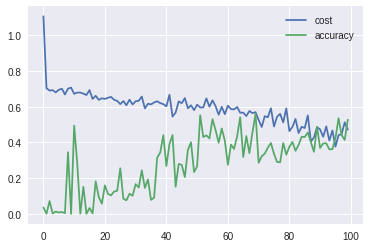

In [15]:
#@title Hyper-parameter Settings for Training { form-width: "20%" }
learning_rate = 0.001 #@param {type:"number"}
training_epochs = 100 #@param {type:"integer"}
batch_size = 100 #@param {type:"integer"}


tf.reset_default_graph();
        
# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print("Train data count: ", len(train), len(train_labels))
print("Validation data count: ", len(valid), len(valid_labels))

print('Learning Started!')

cost, accuracy = [], []

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train) / batch_size)

    for i in trange(total_batch, desc='Batch loop'):
        start_idx = i       * batch_size;
        end_idx   = (i + 1) * batch_size;
        
        batch_xs  = train       [start_idx:end_idx,:,:,:]
        batch_ys  = train_labels[start_idx:end_idx,:]
        
        c, _ = m1.train(batch_xs, batch_ys)
        
        avg_cost += c / total_batch

    a = m1.get_accuracy(valid, valid_labels)
    
    print('\nEpoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy=', '{:.9f}'.format(a))
    
    cost.append(c)
    accuracy.append(a)
    

print('Learning Finished!')

plt.plot(cost, label="cost")
plt.plot(accuracy, label="accuracy")
plt.legend()
plt.show()


##**Prediction**